# Использование моделей АРСС

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    import sktime
except:
    !pip install sktime --user
    !pip install pmdarima
    !pip install statsmodels
    !pip install prophet
import sktime

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [4]:
from sktime.utils.plotting import plot_series
from sktime.transformations.series.detrend import Deseasonalizer

from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima   import ARIMA, AutoARIMA
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.base   import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arch import StatsForecastARCH, StatsForecastGARCH
from sktime.forecasting.model_selection import temporal_train_test_split


from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter("ignore", FutureWarning)

Загружаем датасет как в Юните 10

Check splitted data size: Train: 158, Test: 67


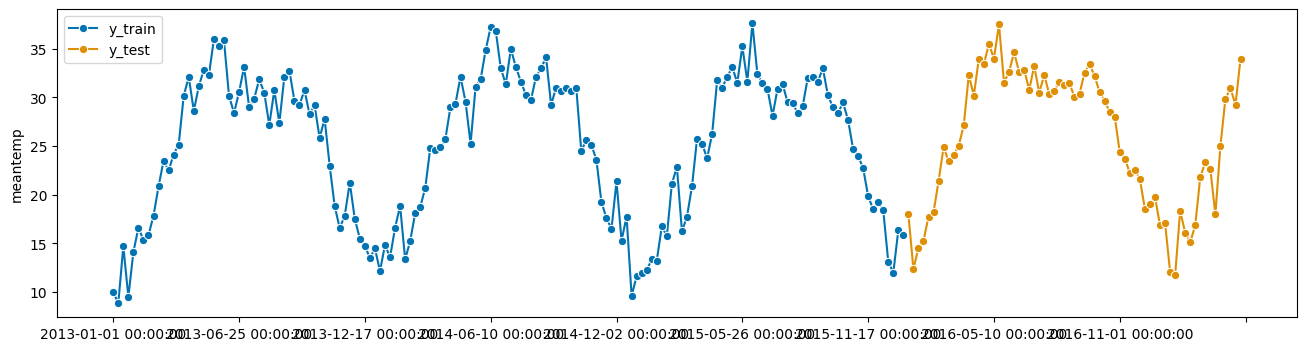

In [6]:
path_ts1 = 'DailyDelhiClimateTrain.csv'
path_ts2 = 'DailyDelhiClimateTest.csv'
df1 = pd.read_csv(path_ts1, parse_dates=['date'], index_col="date")
df2 = pd.read_csv(path_ts2, parse_dates=['date'], index_col="date")
df = pd.concat([df1, df2])
df_unique = df[~df.index.duplicated()].copy() 
# df = pd.read_csv(path_ts)
# df=df.fillna(df.mean())
df = df_unique
y = df.meantemp.asfreq('7d')

TEST_SIZE = int(0.3*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

plot_series(y_train, y_test, labels=["y_train", "y_test"]);

## SARIMA Forecasting

Проверим стационарность для нашего ряда. Для этого используем метод `rolling`

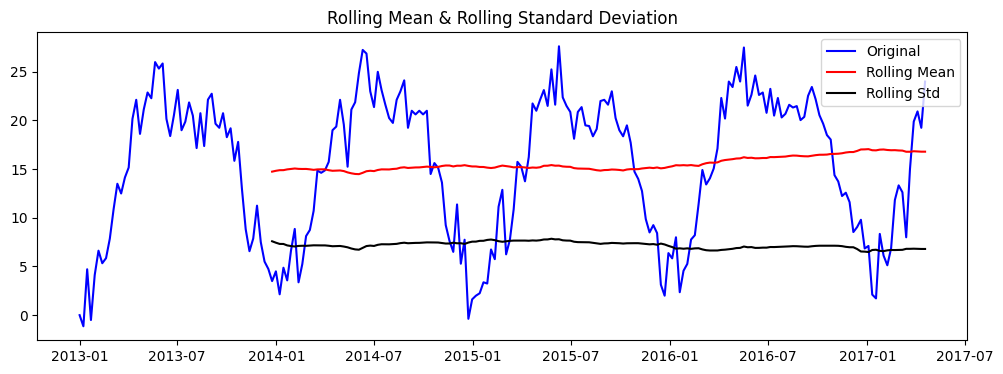

In [7]:
rolling_mean = y.rolling(window = 52).mean()
rolling_std  = y.rolling(window = 52).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y-y[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-y[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Также проверим стационарность при помощи теста Дика-Фуллера

In [8]:
P_THRESHOLD = 0.01
def check_ADF(y, p_threshold = P_THRESHOLD):
    print('Augmented Dickey-Fuller Test')
    result = adfuller(y,autolag='AIC')
    adf_value = result[0]
    p_value   = result[1]
    lags_used = result[2]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('lags_used: {:.1f}'.format(lags_used))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))    
    print(f'Result: The series is {"not " if p_value > p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

Augmented Dickey-Fuller Test
ADF Statistic: -4.1740
p-value: 0.0007
lags_used: 8.0
Critical Values:
	1%: -3.4750, 
	5%: -2.8811, 
	10%: -2.5772, 
Result: The series is stationary


Ряд стационарен

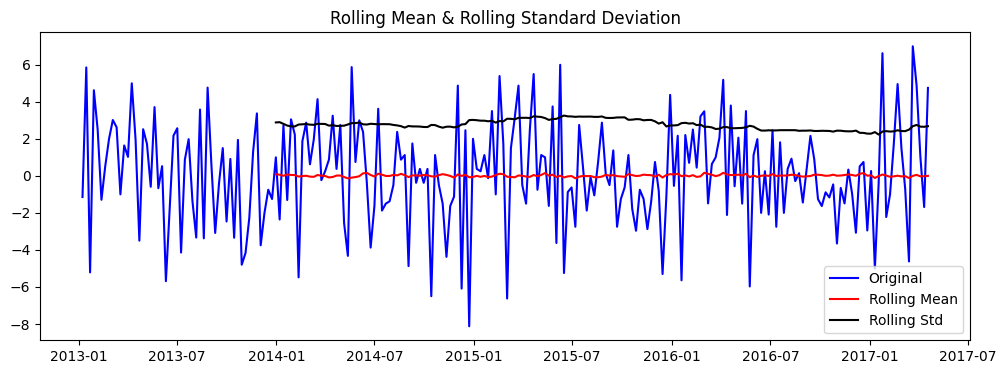

Augmented Dickey-Fuller Test
ADF Statistic: -3.5891
p-value: 0.0060
lags_used: 5.0
Critical Values:
	1%: -3.4607, 
	5%: -2.8749, 
	10%: -2.5739, 
Result: The series is stationary


In [9]:
y_diff = y[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 52).mean()
rolling_std  = y_diff.rolling(window = 52).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

Попробуем также модель с сезонным дифференцированием для сравнения

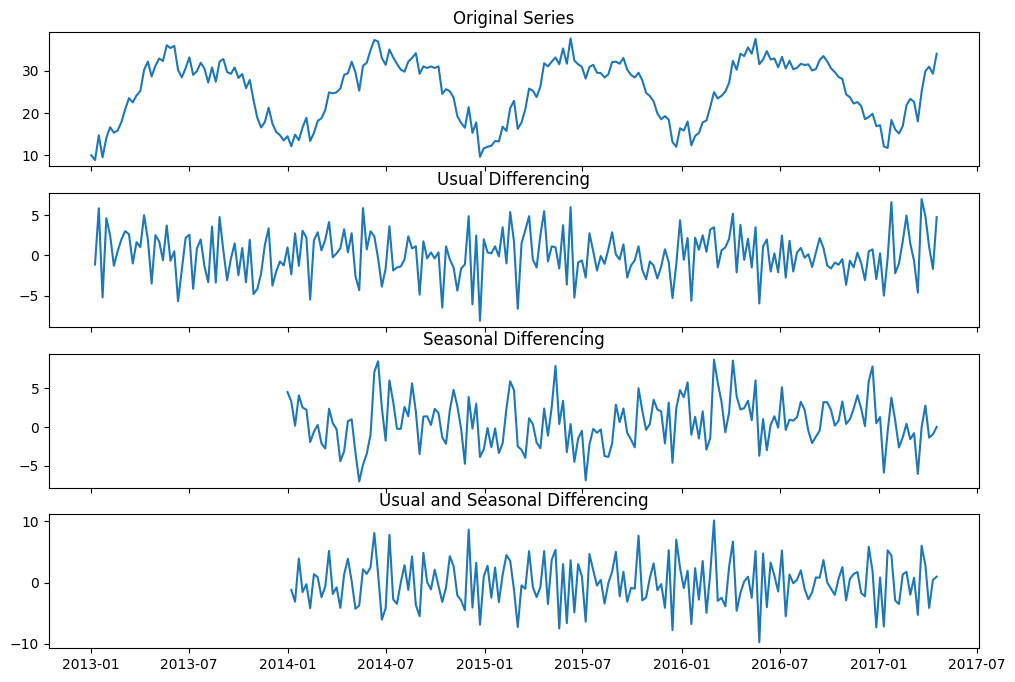

In [10]:
SEASON = 52

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.show()

Сезонная производная не изменила ситуации.

Рассмотрим графики `ACF` и `PACF`.

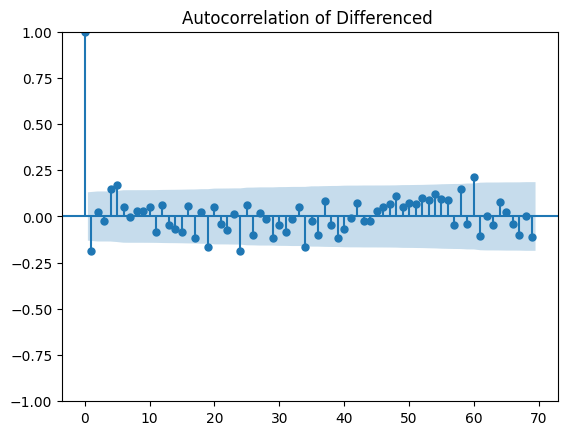

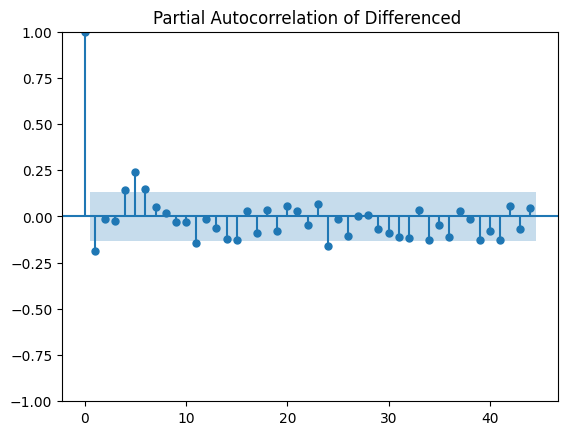

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Usual Differencing
plot_acf(y_diff, title='Autocorrelation of Differenced ', lags=np.arange(70) );plt.show()
# Usual Differencing
plot_pacf(y_diff, title='Partial Autocorrelation of Differenced ', method='ywm', lags=np.arange(45));plt.show()
plt.show();

In [81]:
forecaster = SARIMAX(order=(2, 1, 2), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                  158
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 52)   Log Likelihood                -266.690
Date:                             Mon, 06 May 2024   AIC                            545.380
Time:                                     16:52:59   BIC                            561.304
Sample:                                 01-01-2013   HQIC                           551.833
                                      - 01-05-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0046      0.024     -0.187      0.852      -0.052       0.043
ar.L1         -0.6164      

Из графиков выше следует следующий выбор параметров.
* $2$ порядка `AR`  ($2$ лаги `PACF` ниже нуля); 
* $1$ порядок `MA`  (на `ACF` видна некоторая нестационарность, но 1 и 2 лаги не превысили доверительный интервал);
* $2$ порядок `SAR` (`PACF` есть пара заметных лагов выше нуля);
* $0$ порядок `SMA` (на `ACF` нет значимых лагов ниже нуля);

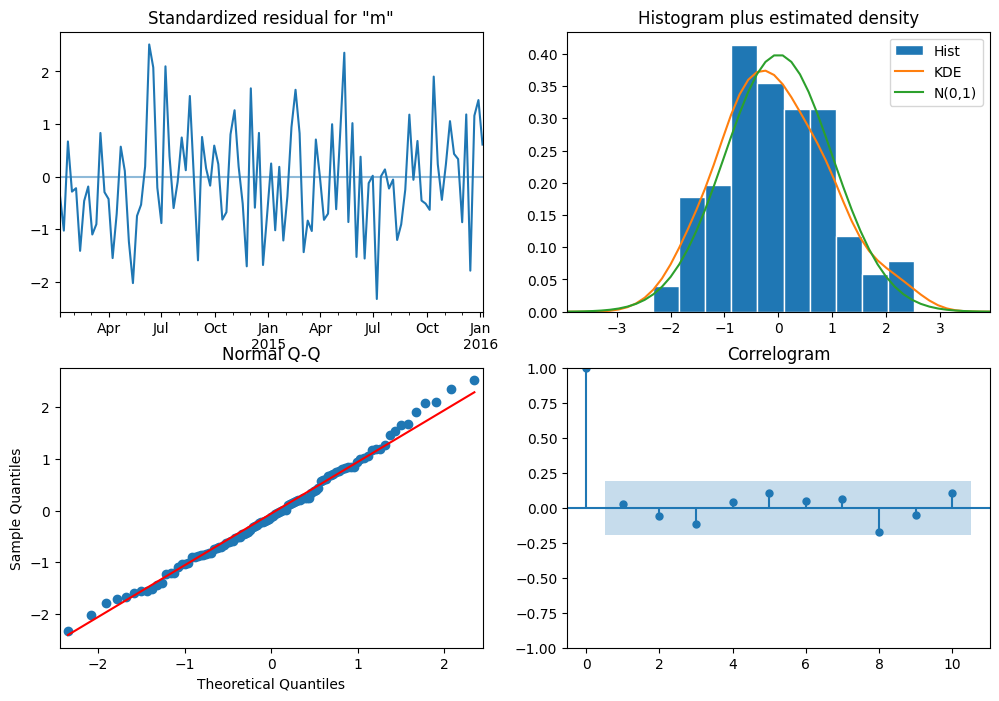

In [82]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

sMAPE = 0.118


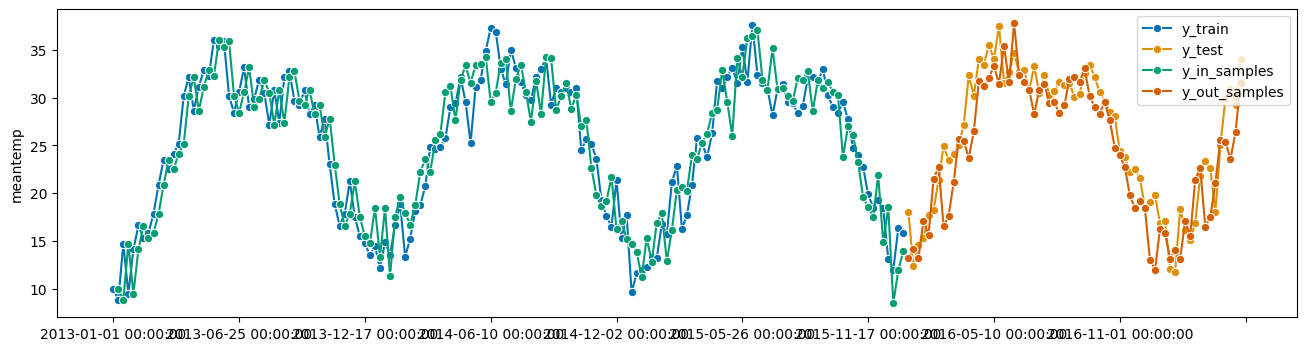

In [83]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                  158
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 52)   Log Likelihood                -266.690
Date:                             Mon, 06 May 2024   AIC                            545.380
Time:                                     16:53:34   BIC                            561.304
Sample:                                 01-01-2013   HQIC                           551.833
                                      - 01-05-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0046      0.024     -0.187      0.852      -0.052       0.043
ar.L1         -0.6164      

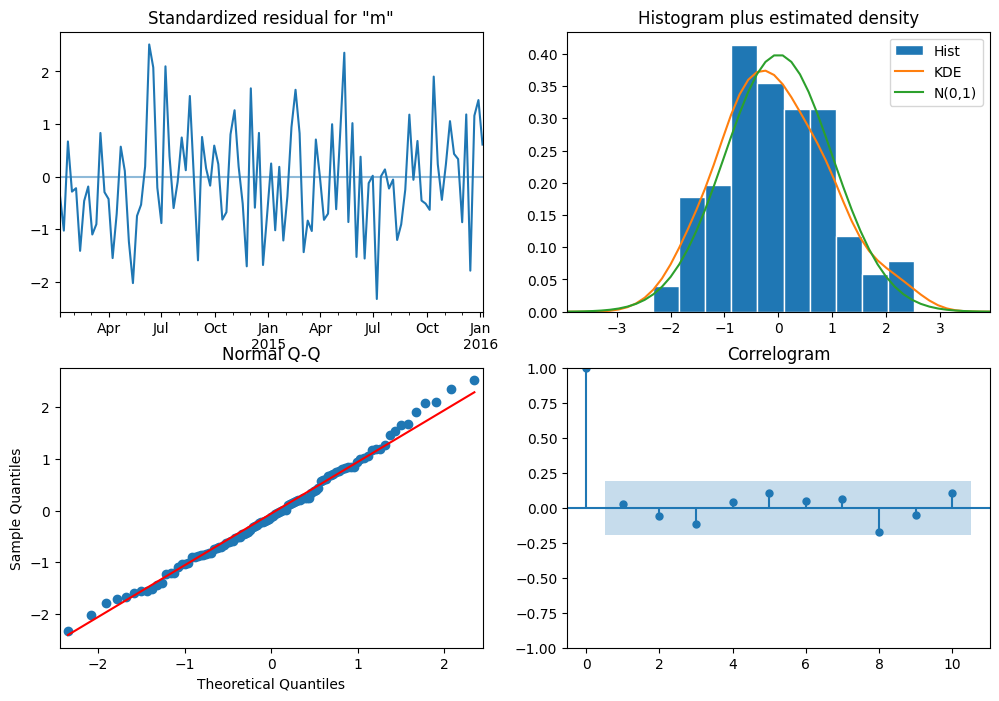

In [85]:
forecaster = SARIMAX(order=(2, 1, 2), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

sMAPE = 0.118


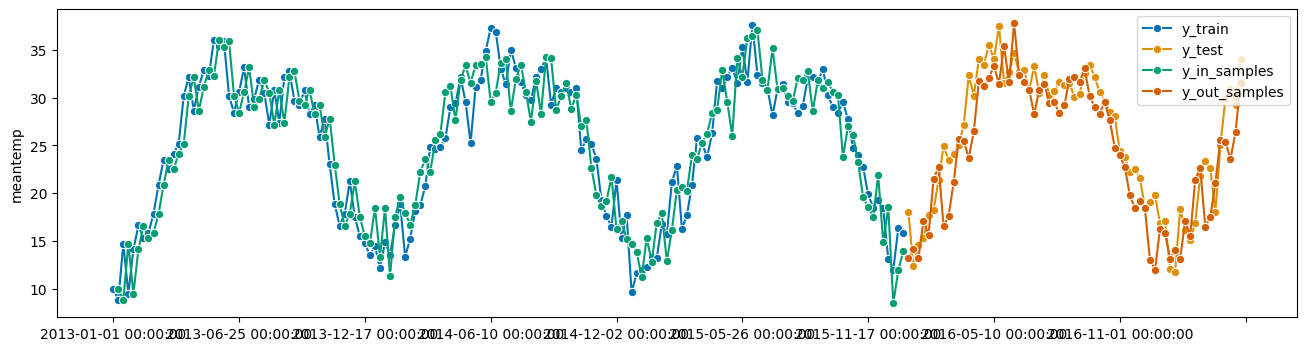

In [86]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

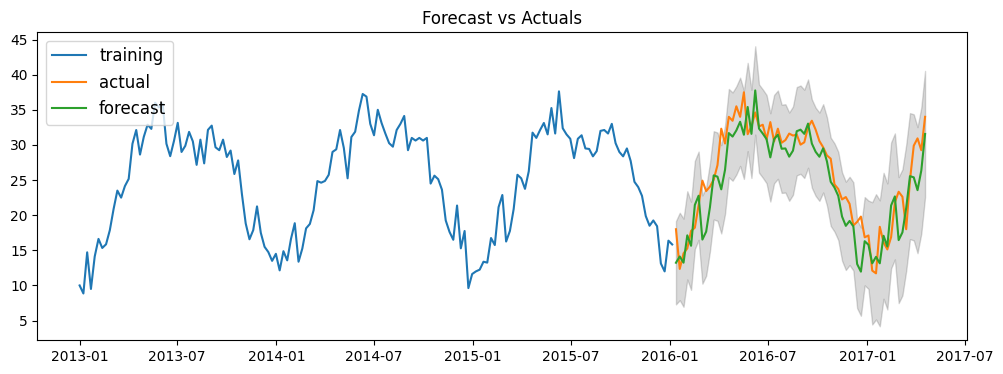

In [87]:
forecaster = SARIMAX(order=(2, 1, 2), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train)
# print(forecaster.summary())
# forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

# Forecast
forecast_res = forecaster._fitted_forecaster.get_forecast(y_test.size, alpha=0.01, dynamic=False)  # 95% conf

forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=y_test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower meantemp'], index=y_test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper meantemp'], index=y_test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train, label='training')
plt.plot(y_test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()


In [88]:
model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=0,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=5,    # конечный порядок MA                 
                  seasonal=True,  # Использовать SARIMA  
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA                 
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 7, # Максимальный порядок p+q+P+Q 
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',  
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=568.828, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=577.251, Time=0.25 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=560.720, Time=2.74 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=6.69 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=575.252, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[52] intercept   : AIC=inf, Time=36.71 sec
 ARIMA(1,1,0)(1,1,1)[52] intercept   : AIC=inf, Time=15.78 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=560.673, Time=3.86 sec
 ARIMA(1,1,0)(0,1,2)[52] intercept   : AIC=inf, Time=24.51 sec
 ARIMA(1,1,0)(1,1,2)[52] intercept   : AIC=inf, Time=35.79 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=569.416, Time=3.34 sec
 ARIMA(2,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(1,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=13.01 sec
 ARIMA(2,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=19.29 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=558.673, Time=3.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  158
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 52)   Log Likelihood                -276.337
Date:                              Mon, 06 May 2024   AIC                            558.673
Time:                                      16:58:48   BIC                            566.635
Sample:                                  01-01-2013   HQIC                           561.899
                                       - 01-05-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3104      0.104     -2.994      0.003      -0.514      -0.107
ma.S.L52      -0.5487      0.264     -2.075      0.038      -1.067      -0.030
sigma2         9.5910      1.984      4.833      0.000       5.702      13.480
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.40   Prob(JB):                         0.76
Heteroskedasticity (H):               0.75   Skew:                             0.04
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

С выбранными вручную параметрами эти не совпали вообще. Проверим на практике.

sMAPE = 0.142


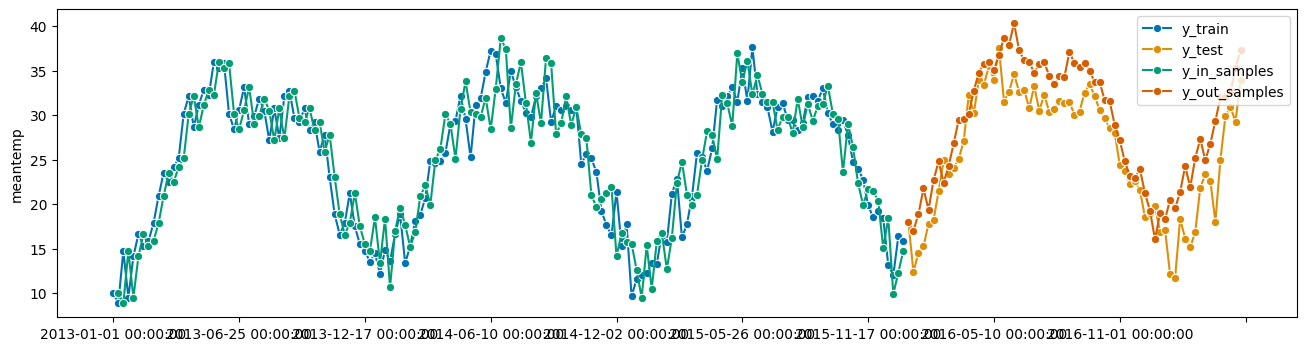

In [89]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = model.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = model.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Результат не фантастический

In [90]:
model = StatsForecastAutoARIMA(start_p=1,  # начальный порядок AR
                              d=1,        # Порядок производной
                              start_q=0,  # начальный порядок MA
                              max_p=5,    # конечный порядок AR
                              max_q=5,    # конечный порядок MA                 
                              seasonal=True,  # Использовать SARIMA  
                              start_P=0,  # начальный порядок SAR
                              start_Q=0,  # начальный порядок SMA                 
                              D=1,        # Порядок сезонной производной
                              sp=52,      # Период сезонности
                              max_order = 7, # Максимальный порядок p+q+P+Q 
                              trace  = True,   # отчет он-лайн
                              stepwise = True, # метод ускоренного выбора параметров.
                              n_jobs = 1,      # для stepwise парралелизм не доступен.
                              )

model.fit(y_train)

# model.summary()

C:\Users\Killroy\AppData\Roaming\Python\Python311\site-packages\sktime\forecasting\base\adapters\_generalised_statsforecast.py:120: UserWarning: Keyword arguments "num_cores" will be omitted as they are not found in the __init__ method from <class 'statsforecast.models.AutoARIMA'>. Check your statsforecast version to find out the right API parameters.
  warn(warning_message)
C:\Users\Killroy\AppData\Roaming\Python\Python311\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Killroy\AppData\Roaming\Python\Python311\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Killroy\AppData\Roaming\Python\Python311\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Killroy\AppData\Roaming\Python\Python311\site-packages\statsforecast\arima.py:913: UserWarn

Fitting models using approximations to speed things up

ARIMA(1,1,0)(0,1,0)[52]                   :153.52078398227104

ARIMA(0,1,0)(0,1,0)[52]                   :161.0677398144052

ARIMA(1,1,0)(1,1,0)[52]                   :130.15511671358934

ARIMA(0,1,1)(0,1,1)[52]                   :125.18967649084821

ARIMA(0,1,1)(0,1,0)[52]                   :135.38103290774487

ARIMA(0,1,1)(1,1,1)[52]                   :inf

ARIMA(0,1,1)(1,1,0)[52]                   :94.57192312548598

ARIMA(0,1,0)(1,1,0)[52]                   :147.94669317541872

ARIMA(1,1,1)(1,1,0)[52]                   :102.01556614136965

ARIMA(0,1,2)(1,1,0)[52]                   :inf

ARIMA(1,1,2)(1,1,0)[52]                   :inf

ARIMA(1,1,2)(1,1,0)[52]                   :inf
Now re-fitting the best model(s) without approximations...


ARIMA(0,1,1)(1,1,0)[52]                   :534.1979584831389


StatsForecastAutoARIMA(D=1, d=1, max_order=7, n_jobs=1, sp=52, start_P=0,
                       start_Q=0, start_p=1, start_q=0, trace=True)

sMAPE = 0.102


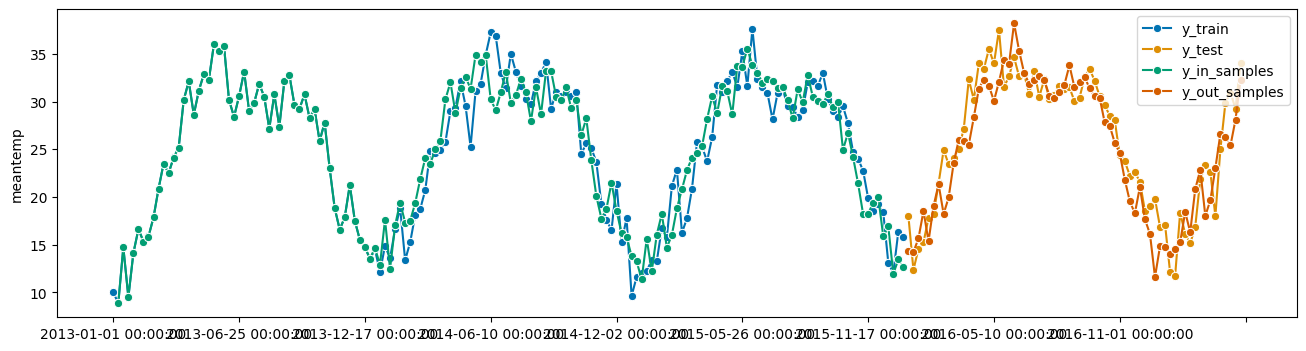

In [91]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = model.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = model.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Чуть лучше, но на уровне наивных предсказаний

sMAPE = 0.117


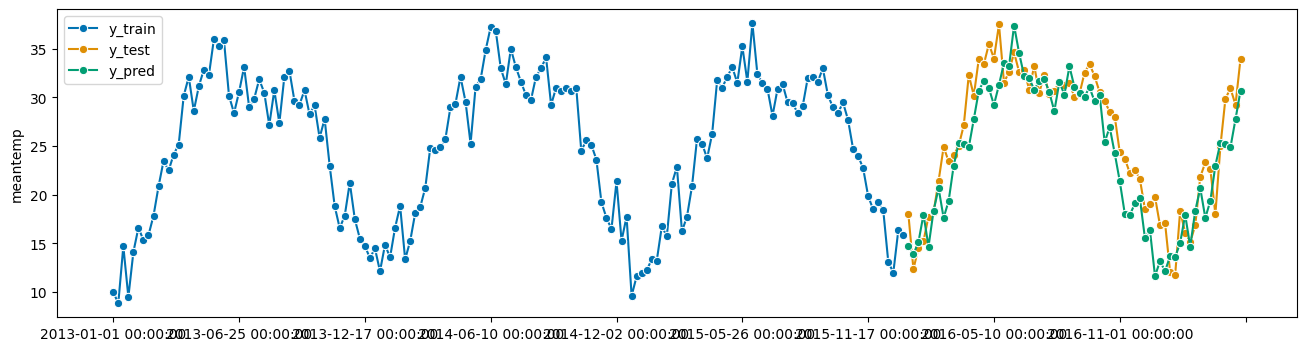

In [92]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", ARIMA( order=(1, 0, 0), seasonal_order=(0, 0, 0, 0),  )),
    ]
)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Аналогично

16:59:23 - cmdstanpy - INFO - Chain [1] start processing
16:59:24 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.096


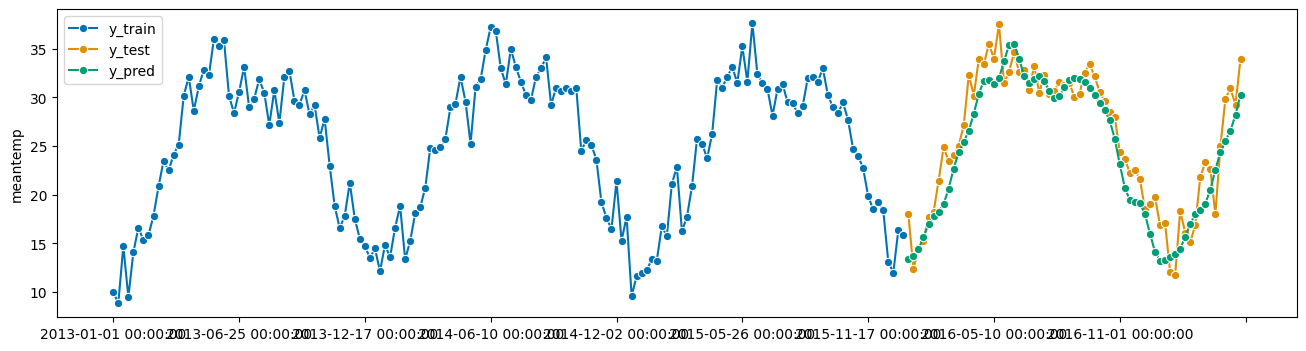

In [93]:
forecaster = Prophet(freq='1w',
                    seasonality_mode='additive',
                    add_country_holidays={'country_name': 'Germany'},
                    yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

После правильной настройки метод алгоритм `Prophet` оказался чуть лучше - как и в исходном примере, хотя и чуть хуже, чем ансамблевый алгоритм. 